In [245]:
!pip install backtrader

In [246]:
!pip install yfinance

In [247]:
import backtrader as bt

In [248]:
class EndOfMonth(object):
    def __init__(self, cal):
        self.cal = cal
        
    def __call__(self, d):
        if self.cal.last_monthday(d):
            return True
        return False

In [249]:
class BuyAndHoldWateringFund(bt.Strategy):
    params = dict(
        monthly_cash=1000.0,  # amount of cash to buy every month
        cal=None
    )

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

        # Activate the fund mode and set the default value at 100
        # self.broker.set_fundmode(fundmode=True, fundstartval=100.00)

        self.cash_start = self.broker.get_cash()
        # Add a timer which will be called on the last trading day of the month
        self.add_timer(
           when=bt.timer.SESSION_END,  # when it will be called
           allow=EndOfMonth(self.p.cal)
        )
    
    def log(self, txt, dt=None):
        # Logging function for this strategy
        dt = dt or self.datas[0].datetime.date(0)
        print('{}, {}'.format(dt.isoformat(), txt))

    # next()
    # This method will be called for all remaining data points when the minimum period for all datas/indicators have been meet.
    def next(self):
        # "next" seems to be called at every market opening date
        # self.log('Close, {:. 2f}'.format(self.dataclose[0]))
        self.log("next called: {}".format(self.broker.get_value()))

        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
              # current close less than previous close
              if self.dataclose[-1] < self.dataclose[-2]:
                  # previous close less than the previous close

                  # BUY, BUY, BUY!!! (with default parameters)
                  self.log('BUY CREATE, %.2f' % self.dataclose[0])

                  # Keep track of the created order to avoid a 2nd order
                  self.order = self.buy()
        else:
            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

    # Receives an order whenever there has been a change in one
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    # Receives a trade whenever there has been a change in one
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def notify_timer(self, timer, when, *args, **kwargs):
        # Add the influx of monthly cash to the broker
        self.broker.add_cash(self.p.monthly_cash)

        # buy available cash
        target_value = self.broker.get_value() + self.p.monthly_cash
        print('notify_timer called: Target_value {}'.format(target_value))
        self.order_target_value(target=target_value)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() - self.cash_start) - 1.0
        print('ROI: {:.2f}%'.format(self.roi))


**Custom Analyzer Sample**

```python
from collections import OrderedDict 

class CAGRAnalyzer(bt.analyzers.Analyzer):
    """
    Analyzer returning CAGR of the portfolio
    """

    def nextstart(self):
        self.rets = OrderedDict()
        self.rets.start_value = self.strategy.broker.getvalue()
        self.rets.start_date = self.strategy.datetime.datetime().date()

    def stop(self):
        self.rets.end_value = self.strategy.broker.getvalue()
        self.rets.end_date = self.strategy.datetime.datetime().date()
        self.rets.num_years = (self.rets.end_date - self.rets.start_date).days / 365.25
        self.rets.cagr = self.calculate_cagr(self.rets.start_value, self.rets.end_value, self.rets.num_years)

    def calculate_cagr(self, start_value, end_value, num_years):
        """
        The CAGR formula is: 
            EV / BV ^ (1/n) – 1. 
        EV and BV are the ending and beginning values, while n is the number of time periods (usually months or years) 
        for which you are calculating an average. The ^ character means “to the power of”; we take the ratio of EV / BV 
        and raise it to the power of 1/n. Subtracting one (one = 100%)
        """
        return ((end_value / start_value) ** (1 / num_years)) - 1
```

In [250]:
# FileNotFoundError: [Errno 2] No such file or directory
# data = bt.feeds.YahooFinanceData(
#    dataname='SOXL', fromdate=datetime(2010, 3, 11), todate=datetime(today.year, today.month, today.day)
#)
# YahooFinanceData data source seems to have a wrong. Instead of the official guide, using the yfinance.
from datetime import datetime
import yfinance as yf

df_data = yf.download('SOXL', start=datetime(2010, 3, 11), end=datetime(2022, 1, 28), auto_adjust=True)
print(type(df_data))
data = bt.feeds.PandasData(dataname=df_data)

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>


In [251]:
df_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-03-11,0.602297,0.619170,0.602297,0.619170,3702000
2010-03-12,0.619639,0.623701,0.603859,0.603859,4548000
2010-03-15,0.591673,0.598078,0.575737,0.584798,534000
2010-03-16,0.592142,0.632920,0.591204,0.632294,1260000
2010-03-17,0.656199,0.662761,0.643231,0.655105,2610000


In [252]:
cerebro = bt.Cerebro()
cal = bt.TradingCalendar()
cerebro.addcalendar(cal)
cerebro.adddata(data)
# Custom parameter
cerebro.addstrategy(BuyAndHoldWateringFund, monthly_cash=1000, cal=cal)
# Set initial cash
# cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001) # 0.1% commision rate

In [253]:
# Set Additional critierias
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.TimeReturn)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
# Set Custom Analyzer
# cerebro.addanalyzer(CAGRAnalyzer, _name="cagr")

In [254]:
print('Starting Portfolio Value: {}'.format(cerebro.broker.getvalue()))
results = cerebro.run()
print('Final Portfolio Value: {}'.format(cerebro.broker.getvalue()))

Streaming output truncated to the last 5000 lines.
2013-10-21, Close, 0.92
2013-10-22, next called: 10000.178932185112
2013-10-22, Close, 0.92
2013-10-23, next called: 10000.178932185112
2013-10-23, Close, 0.83
2013-10-23, BUY CREATE, 0.83
2013-10-24, BUY EXECUTED, 0.84
2013-10-24, next called: 10000.183873529984
2013-10-24, Close, 0.85
2013-10-25, next called: 10000.193250473096
2013-10-25, Close, 0.86
2013-10-28, next called: 10000.210910196854
2013-10-28, Close, 0.87
2013-10-29, next called: 10000.249355669572
2013-10-29, Close, 0.91
2013-10-30, next called: 10000.235915716245
2013-10-30, Close, 0.90
2013-10-31, next called: 10000.251231070115
2013-10-31, Close, 0.91
2013-10-31, SELL CREATE, 0.91
2013-11-01, SELL EXECUTED, 0.92
2013-11-01, OPERATION PROFIT, GROSS 0.08, NET 0.08
2013-11-01, next called: 10000.257654978943
2013-11-01, Close, 0.90
2013-11-04, next called: 10000.257654978943
2013-11-04, Close, 0.90
2013-11-04, BUY CREATE, 0.90
2013-11-05, BUY EXECUTED, 0.88
2013-11-05, 

In [255]:
analyzers = results[0].analyzers
print(analyzers)
mdd = analyzers.drawdown.get_analysis()['max']['drawdown']
# cagr = analyzers.timereturn.get_analysis() # returns in time series
cagr_dict = analyzers.returns.get_analysis()
sharp = analyzers.sharperatio.get_analysis()['sharperatio']

print('MDD: {:.2f}%'.format(mdd))
print('Returns:')
import pprint
pprint.pprint(dict(cagr_dict.items()))
print('Sharpe Ratio: {:.2f}%'.format(sharp)) if sharp else None

MDD: 0.29%
Returns:
{'ravg': 1.0810318377042538e-06,
 'rnorm': 0.0002724571328056976,
 'rnorm100': 0.027245713280569756,
 'rtot': 0.0032355282902488316}
Sharpe Ratio: 0.16%


<IPython.core.display.Javascript object>

[[<Figure size 3600x3200 with 4 Axes>]]

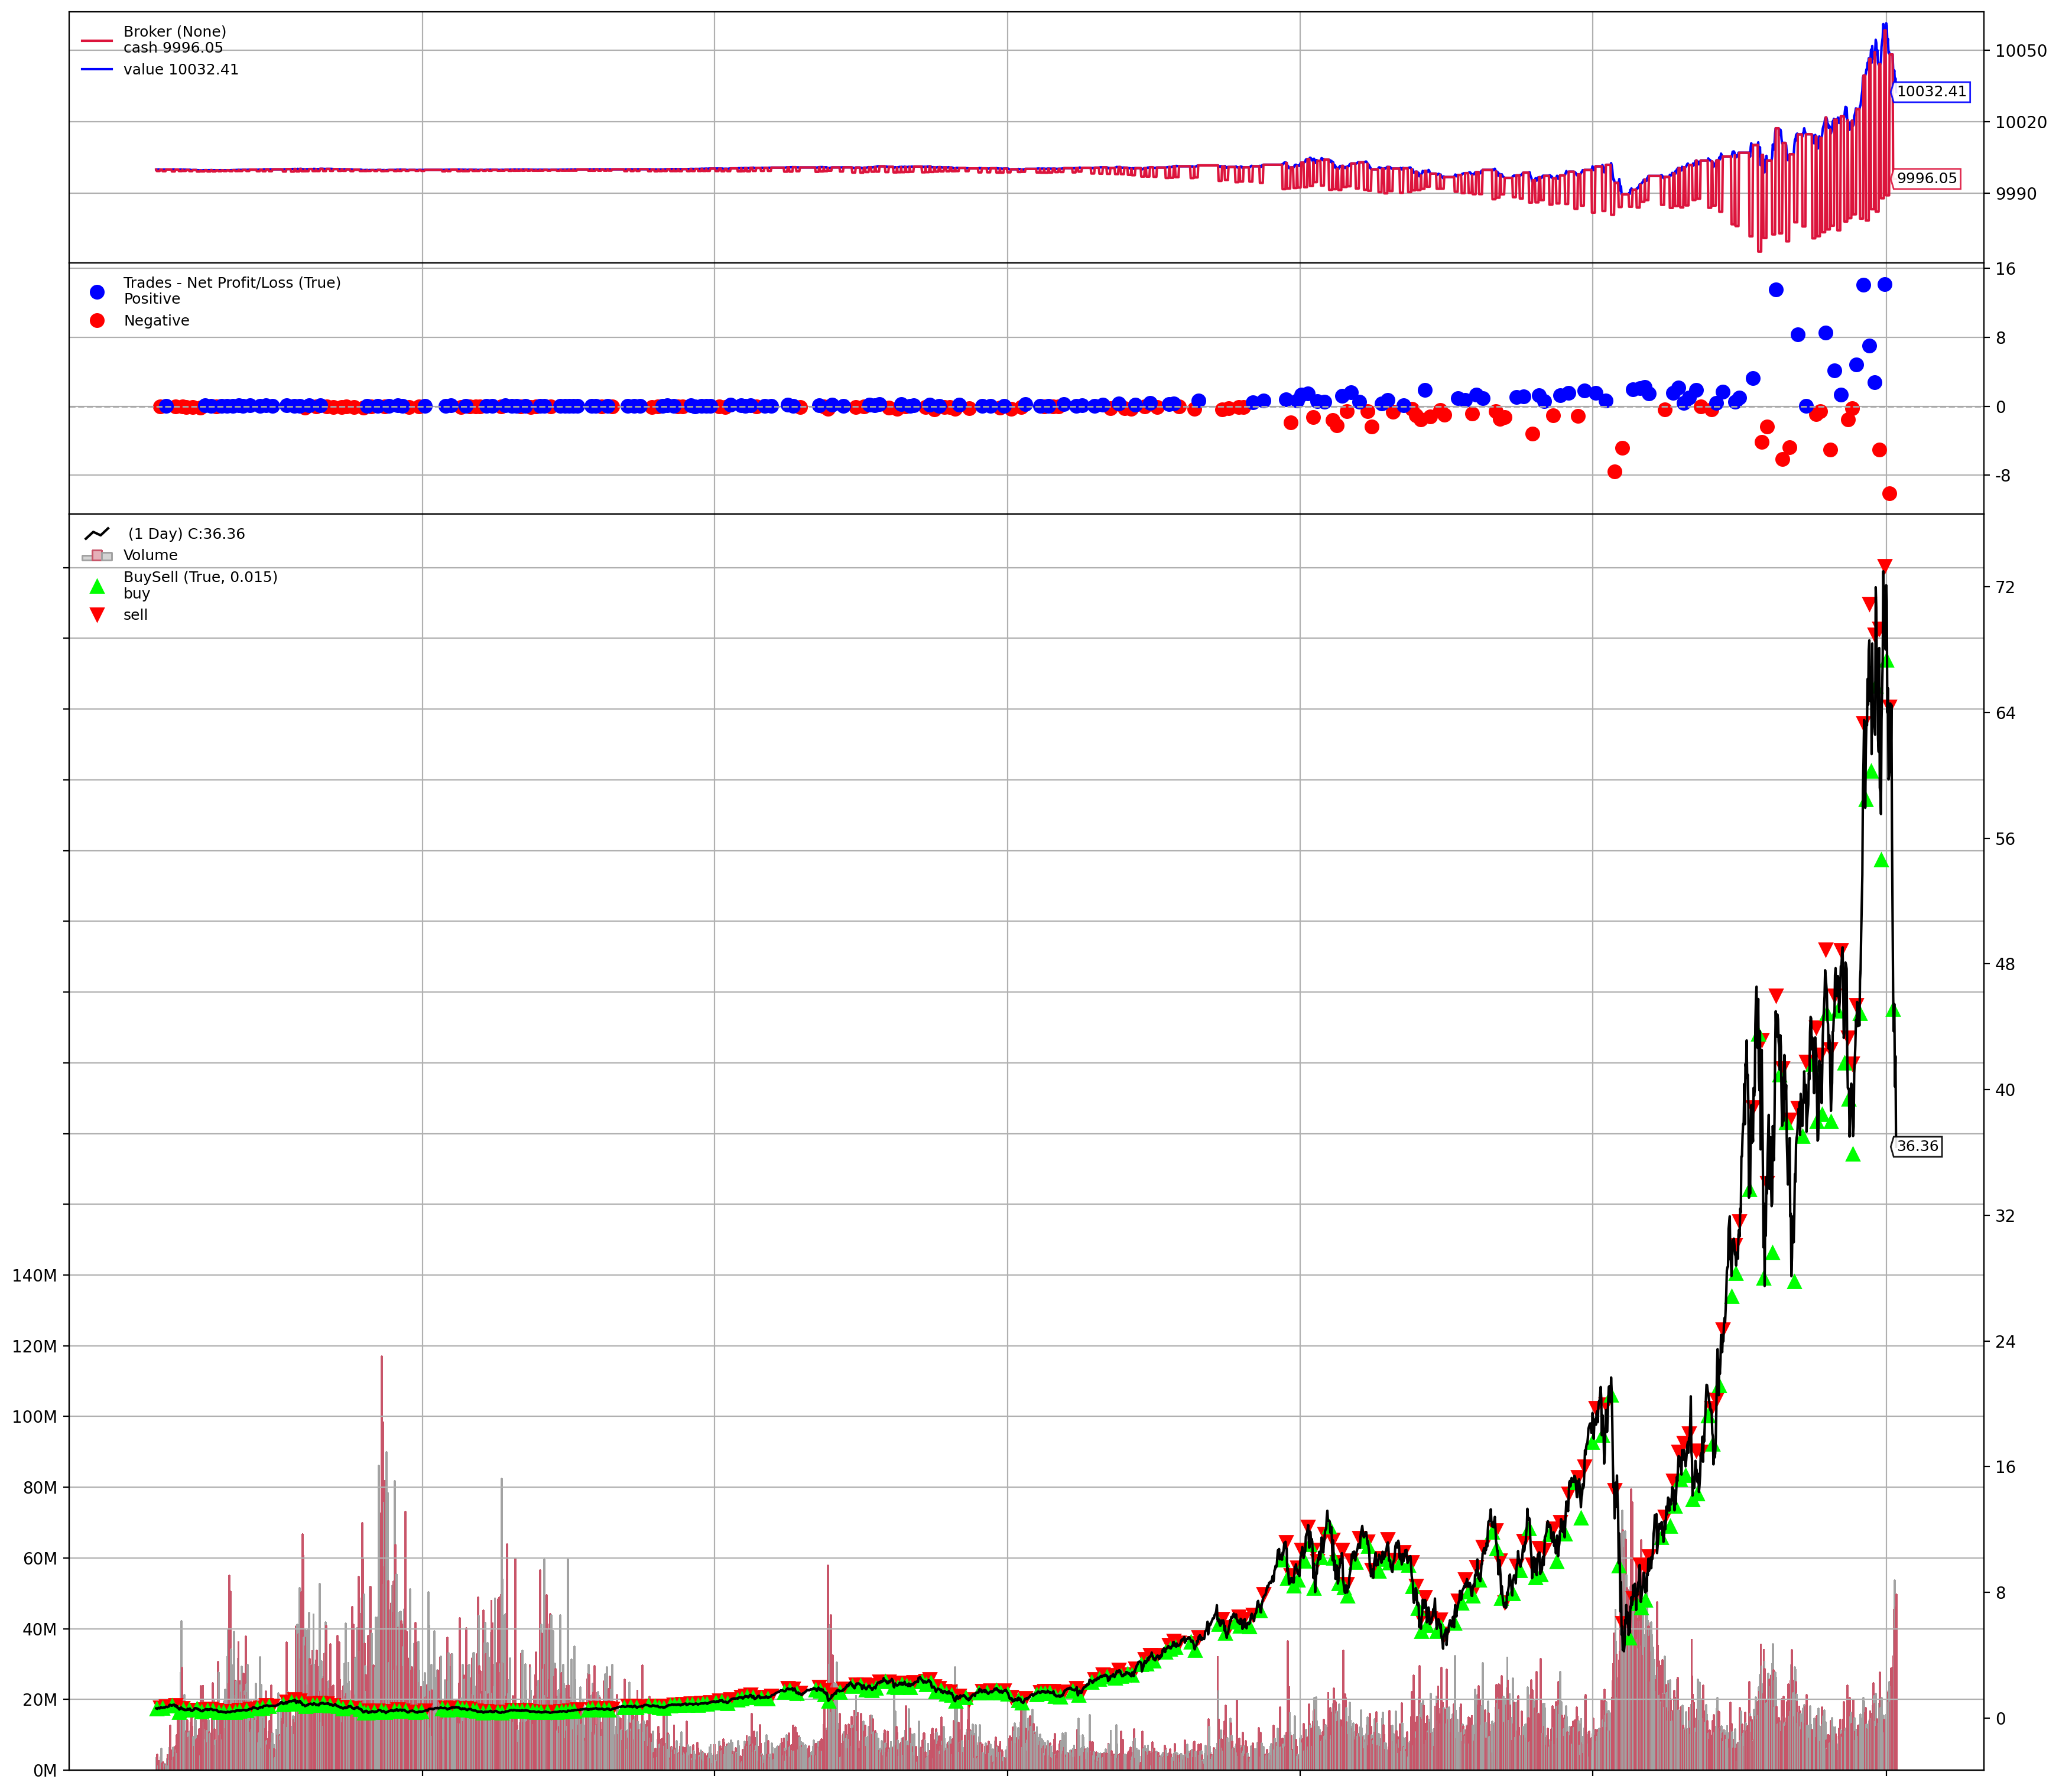

In [244]:
# Without parameters below, the plot is going to be distorted.
import matplotlib as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=[18, 16]
plt.rcParams['figure.dpi']=200
plt.rcParams['figure.facecolor']='w'
plt.rcParams['figure.edgecolor']='k'
cerebro.plot(iplot=True)